In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import random
import itertools
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from tqdm import *

import keras
from keras.applications import *
import lightgbm as lgbm
from scipy import stats
from keras.models import Sequential, Model
from keras.layers import * #Dense, Dropout, Activation, Flatten, Input,Concatenate, concatenate
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import cv2 as cv
from os import listdir
from os.path import isfile, join
from scipy import misc
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop

Using TensorFlow backend.


In [2]:
plt.ion()
plt.show()

In [3]:
basedir = 'data/dogs/'
files = [f for f in listdir(basedir) if isfile(join(basedir, f))]
len(files)
img_size = 240

In [4]:
def normalize(arr):
    arr=arr.astype('float32')
    if arr.max() > 1.0:
        arr/=255.0
    return arr

def resizeImg(Xg):
#     cv.normalize(Xg,  Xg, 0, 1, cv.NORM_MINMAX)
#     Xg/=255.0
    Xg = normalize(Xg)
    if Xg.shape[0] >= img_size:
        return cv.resize(Xg,(img_size,img_size), cv.INTER_AREA)
    else:
        return cv.resize(Xg,(img_size,img_size), cv.INTER_CUBIC)

    
def readAndResize(filename):
    dog = misc.imread(basedir + filename)
    return resizeImg(dog)

(240, 240, 3)


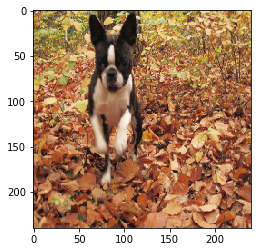

In [5]:
dog = readAndResize(files[0])
print(dog.shape)
plt.imshow(dog)
# readAndResize(files[0])

(375, 500, 3)


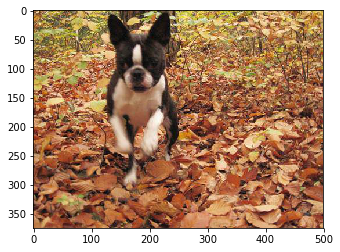

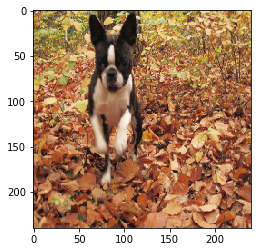

In [6]:
dog = misc.imread(basedir + files[0])
print(dog.shape)
plt.imshow(dog)
plt.show()
plt.imshow(resizeImg(dog))
plt.show()

In [7]:
def getInputImages(ids):
    data = [readAndResize(i) for i in  ids]
    data = np.stack(data)
    return data

In [34]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.acc = [] #
        self.fig = plt.figure()
        self.logs = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):     
        self.i += 1

        if self.i% 1 != 0:
            return
        
        self.losses.append(logs.get('loss'))

        self.acc.append(logs.get('acc'))
        self.logs.append(logs)
        self.x.append(self.i)
        
        clear_output(wait=True)
        plt.figure(figsize=(16,8))
        plt.subplot(1,3,1)
        self.plotLosses(None)
        

        

    def plotLosses(self, ax):
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.acc, label="accuracy")

        plt.legend()
        
        
myPlot = PlotLosses()
myPlot.initVars()

## GAN

In [9]:
img_size = 240
img_rows = img_size
img_cols = img_size
channels = 3
img_shape = (img_rows, img_cols, channels)
epochs = 100
batch_size = 20
save_interval= 10
half_batch = int(batch_size / 2)



In [57]:
def build_generator():

    noise_shape = (100,)
    noise = Input(shape=noise_shape)
    depth = 64 *4
    dim = 10

    x = Dense(dim * dim *depth, activation='relu', input_shape=noise_shape)(noise)
    x = BatchNormalization(momentum=0.9)(x)
#     x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((dim, dim, depth))(x)
    x = Dropout(0.4)(x)
    
    x = UpSampling2D((4,4))(x)
    x = Conv2DTranspose(int(depth/2), 5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    
    x = UpSampling2D((3,3))(x)
    x = Conv2DTranspose(int(depth/4), 5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(int(depth/8), 5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    
    
    x = Conv2DTranspose(3, 5, padding='same')(x)
    model = Model(noise, x)


    model.compile(optimizer=RMSprop(lr=0.0002, decay=6e-8), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=Adam(0.0001, 0.3), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return Model(noise, x)

generator = build_generator()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 25600)             2585600   
_________________________________________________________________
batch_normalization_33 (Batc (None, 25600)             102400    
_________________________________________________________________
reshape_9 (Reshape)          (None, 10, 10, 256)       0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 10, 10, 256)       0         
_________________________________________________________________
up_sampling2d_25 (UpSampling (None, 40, 40, 256)       0         
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 40, 40, 128)       819328    
__________

In [58]:

def build_discriminator():
    img_shape = (img_rows, img_cols, channels)
    input_img = Input(shape=img_shape)
    depth = 64
    x = Convolution2D(depth, (5, 5), activation='relu', padding='same', input_shape=img_shape)(input_img)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
    x = LeakyReLU(0.2) (x)
    x = Dropout(0.6)(x)
    
    x = Convolution2D(depth *2 , (4, 4), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
    x = LeakyReLU(0.2) (x)
    x = Dropout(0.6)(x)
    
    x = Convolution2D(depth *4, (3, 3),  activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
    x = LeakyReLU(0.2) (x)
    x = Dropout(0.6)(x)
    
    x = Convolution2D(depth *8, (3, 3),  activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
    x = LeakyReLU(0.2) (x)
    x = Dropout(0.6)(x)

#     x = Convolution2D(16, (3, 3),  activation='relu', padding='same')(x)
#     x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
#     x = Dropout(0.6)(x)
#     x= AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = Flatten(input_shape=img_shape)(x)
#     x = Dense(512)(x)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(input_img, x)

#     model.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
#categorical_accuracy
    model.compile(optimizer=RMSprop(lr=0.0001, decay=3e-8), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=Adam(0.0001, 0.3), loss='categorical_crossentropy', metrics=['accuracy'])
    

    model.summary()
    return model

discriminator = build_discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 240, 240, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 240, 240, 64)      4864      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 120, 120, 64)      0         
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 120, 120, 64)      0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 120, 120, 64)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 120, 120, 128)     131200    
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 60, 60, 128)       0         
__________

In [12]:
def save_imgs(epoch):

    noise = np.random.normal(0, 1, (2, 100))
    gen_imgs = generator.predict(noise)
    fig = plt.figure(figsize =(8,12))
    plt.subplot(1,2,1)
    plt.imshow(gen_imgs[0])
    plt.subplot(1,2,2)
#     gen_imgs[1] = 0.5 * gen_imgs[1] + 0.5
    plt.imshow(gen_imgs[1])
    plt.show()
    # Rescale images 0 - 1
#     gen_imgs = 0.5 * gen_imgs + 0.5
#     fig = plt.figure(figsize =())
#     fig, axs = plt.subplots(r, c)
#     cnt = 0
#     for i in range(r):
#         for j in range(c):
#             axs[i,j].imshow(gen_imgs[cnt, :,:,0])
#             axs[i,j].axis('off')
#             cnt += 1
#     plt.show()
#     fig.savefig("gan/images/mnist_%d.png" % epoch)
#     plt.close()


In [56]:
to_categorical(np.ones((2, 1)))

array([[ 0.,  1.],
       [ 0.,  1.]])

## Test discriminator

In [13]:
def getData(size):
    idx = list(np.random.randint(0, len(files), size))
    imgs = getInputImages([files[i] for i in idx])
    noise = np.random.normal(0, 1, (size, 100))
    gen_imgs = generator.predict(noise)
    d_input = np.append(imgs, gen_imgs, axis=0)

    d_output = np.append(np.ones((size, 1), dtype=np.int), np.zeros((size, 1)), axis=0)

    return d_input, d_output
    

In [14]:
getData(2)
1

1

In [1]:
# half_batch = 2
# for epoch in range(100):

#     d_input, d_output = getData(half_batch)
#     discriminator.fit(d_input, d_output, epochs = 1)
#     pred1 = discriminator.predict(d_input)

    
#     t_input, t_output = getData(2)

#     pred = (discriminator.predict(t_input) > 0.5).astype(int)

#     print('accuracy_score : ' , accuracy_score(pred, t_output))


In [42]:
%matplotlib notebook
accuracyFig = plt.figure(figsize=(9,4))
accuracyFig.clf()

[0, 1, 2]

Epoch 1/3
8/8 [==============================] - 9s - loss: 0.5074 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 7s - loss: 0.7298 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 6s - loss: 1.2605 - acc: 0.5000
history :  {'loss': [0.50740689039230347, 0.72976332902908325, 1.2604877948760986], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  1.19209e-07


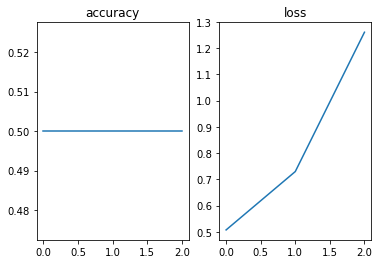

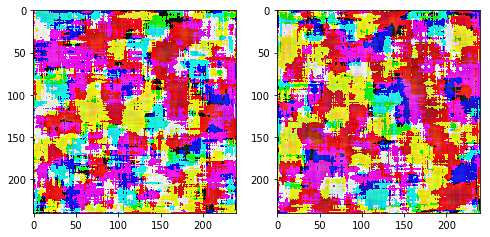

Epoch 1/3
8/8 [==============================] - 7s - loss: 0.9251 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 7s - loss: 0.5575 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 7s - loss: 0.4397 - acc: 0.7500
history :  {'loss': [0.92511624097824097, 0.55746740102767944, 0.43973225355148315], 'acc': [0.5, 0.5, 0.75], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  0.3609
Epoch 1/3
8/8 [==============================] - 6s - loss: 0.7849 - acc: 0.3750
Epoch 2/3
8/8 [==============================] - 7s - loss: 1.7364 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 8s - loss: 3.0256 - acc: 0.5000
history :  {'loss': [0.78487950563430786, 1.736424446105957, 3.0256490707397461], 'acc': [0.375, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  1.19209e-07
Epoch 1/3
8/8 [==============================] - 7s - loss: 3.0055 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 7s - loss: 1.2212 - a

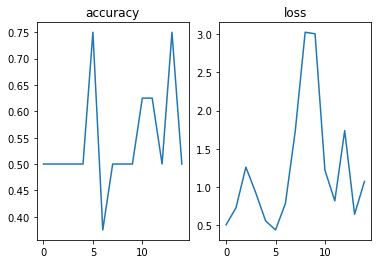

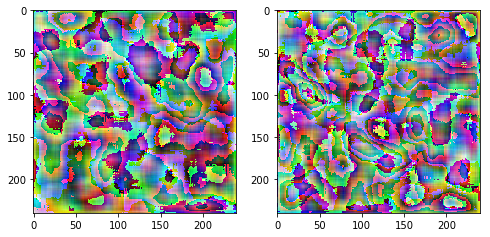

Epoch 1/3
8/8 [==============================] - 8s - loss: 1.4433 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 8s - loss: 5.1914 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 10s - loss: 1.1610 - acc: 0.6250
history :  {'loss': [1.4432661533355713, 5.1913962364196777, 1.1610040664672852], 'acc': [0.5, 0.5, 0.625], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  0.00144444
Epoch 1/3
8/8 [==============================] - 8s - loss: 1.9263 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 7s - loss: 1.2762 - acc: 0.6250
Epoch 3/3
8/8 [==============================] - 7s - loss: 1.0974 - acc: 0.6250
history :  {'loss': [1.9262757301330566, 1.2761776447296143, 1.0973838567733765], 'acc': [0.5, 0.625, 0.625], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  6.76445
Epoch 1/3
8/8 [==============================] - 6s - loss: 1.1761 - acc: 0.6250
Epoch 2/3
8/8 [==============================] - 8s - loss: 1.5724 - 

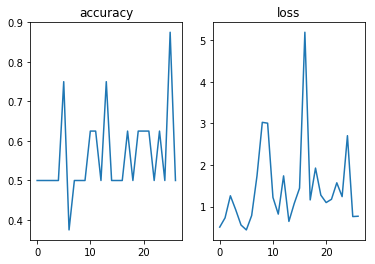

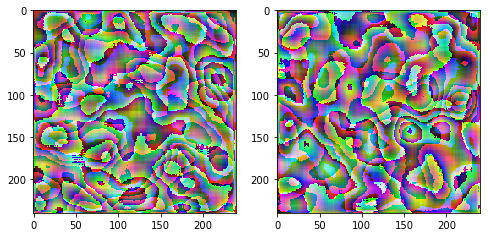

Epoch 1/3
8/8 [==============================] - 7s - loss: 2.8617 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 7s - loss: 3.3531 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 8s - loss: 0.7387 - acc: 0.6250
history :  {'loss': [2.8617353439331055, 3.3530678749084473, 0.7386699914932251], 'acc': [0.5, 0.5, 0.625], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  0.618336
Epoch 1/3
8/8 [==============================] - 7s - loss: 0.3307 - acc: 0.8750
Epoch 2/3
8/8 [==============================] - 8s - loss: 0.3123 - acc: 0.8750
Epoch 3/3
8/8 [==============================] - 7s - loss: 0.4230 - acc: 0.6250
history :  {'loss': [0.33068588376045227, 0.31234192848205566, 0.42300564050674438], 'acc': [0.875, 0.875, 0.625], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  5.57432
Epoch 1/3
8/8 [==============================] - 7s - loss: 1.2196 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 7s - loss: 0.5978 

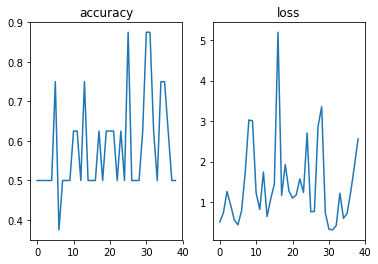

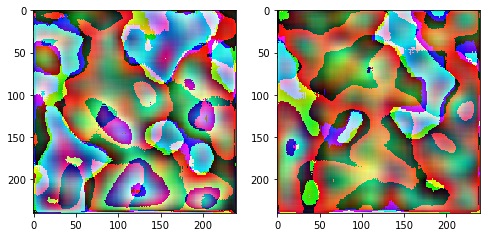

Epoch 1/3
8/8 [==============================] - 6s - loss: 0.5338 - acc: 0.7500
Epoch 2/3
8/8 [==============================] - 6s - loss: 0.6204 - acc: 0.6250
Epoch 3/3
8/8 [==============================] - 7s - loss: 0.7537 - acc: 0.7500
history :  {'loss': [0.53382563591003418, 0.62036800384521484, 0.753681480884552], 'acc': [0.75, 0.625, 0.75], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  0.537699
Epoch 1/3
8/8 [==============================] - 7s - loss: 1.2740 - acc: 0.6250
Epoch 2/3
8/8 [==============================] - 7s - loss: 0.9742 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 7s - loss: 1.9359 - acc: 0.5000
history :  {'loss': [1.2740445137023926, 0.97424912452697754, 1.9358929395675659], 'acc': [0.625, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  1.2424
Epoch 1/3
8/8 [==============================] - 7s - loss: 1.4302 - acc: 0.2500
Epoch 2/3
8/8 [==============================] - 7s - loss: 1.9787 - ac

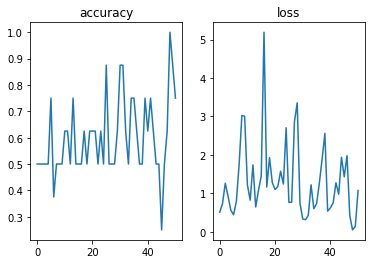

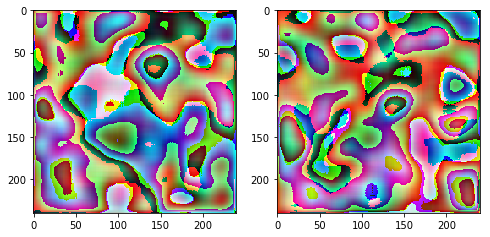

Epoch 1/3
8/8 [==============================] - 6s - loss: 4.3011 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 7s - loss: 0.6758 - acc: 0.8750
Epoch 3/3
8/8 [==============================] - 7s - loss: 2.0017 - acc: 0.6250
history :  {'loss': [4.3010530471801758, 0.67581391334533691, 2.0017318725585938], 'acc': [0.5, 0.875, 0.625], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  15.6063
Epoch 1/3
8/8 [==============================] - 7s - loss: 4.9129 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 7s - loss: 4.3923 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 7s - loss: 1.2341 - acc: 0.5000
history :  {'loss': [4.9129452705383301, 4.3922581672668457, 1.2341437339782715], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  1.61042
Epoch 1/3
8/8 [==============================] - 7s - loss: 0.3516 - acc: 0.8750
Epoch 2/3
8/8 [==============================] - 7s - loss: 1.4382 - acc: 

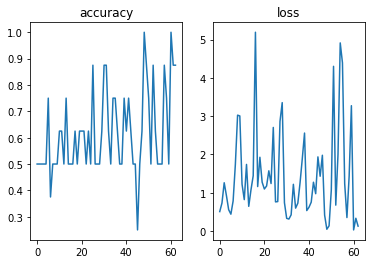

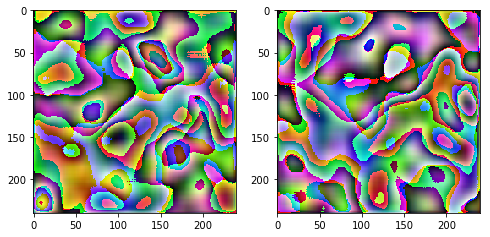

Epoch 1/3
8/8 [==============================] - 7s - loss: 0.0780 - acc: 1.0000
Epoch 2/3
8/8 [==============================] - 7s - loss: 0.1340 - acc: 0.8750
Epoch 3/3
8/8 [==============================] - 7s - loss: 0.8748 - acc: 0.6250
history :  {'loss': [0.077973365783691406, 0.13395363092422485, 0.87479370832443237], 'acc': [1.0, 0.875, 0.625], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  12.8151
Epoch 1/3
8/8 [==============================] - 7s - loss: 2.8375 - acc: 0.6250
Epoch 2/3
8/8 [==============================] - 7s - loss: 5.4730 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 7s - loss: 2.2692 - acc: 0.6250
history :  {'loss': [2.8374972343444824, 5.4730043411254883, 2.2692384719848633], 'acc': [0.625, 0.5, 0.625], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  0.0176027
Epoch 1/3
8/8 [==============================] - 7s - loss: 3.2574 - acc: 0.6250
Epoch 2/3
8/8 [==============================] - 8s - loss: 0.294

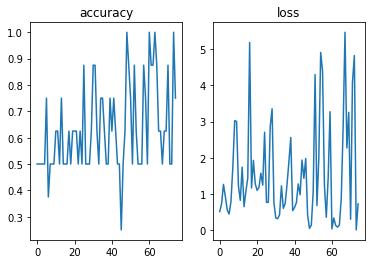

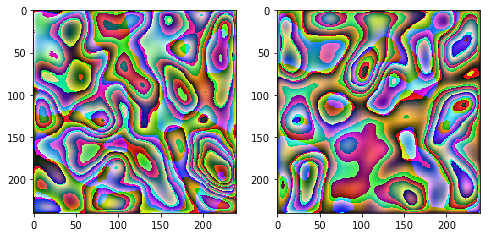

Epoch 1/3
8/8 [==============================] - 7s - loss: 2.8716 - acc: 0.7500
Epoch 2/3
8/8 [==============================] - 7s - loss: 2.0004 - acc: 0.8750
Epoch 3/3
8/8 [==============================] - 7s - loss: 1.4592 - acc: 0.7500
history :  {'loss': [2.8715887069702148, 2.0003805160522461, 1.4591658115386963], 'acc': [0.75, 0.875, 0.75], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  15.7719
Epoch 1/3
8/8 [==============================] - 7s - loss: 1.9658 - acc: 0.6250
Epoch 2/3
8/8 [==============================] - 7s - loss: 0.0500 - acc: 1.0000
Epoch 3/3
8/8 [==============================] - 7s - loss: 1.3911 - acc: 0.5000
history :  {'loss': [1.9657535552978516, 0.049965966492891312, 1.3911041021347046], 'acc': [0.625, 1.0, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  0.00560705
Epoch 1/3
8/8 [==============================] - 7s - loss: 5.9784 - acc: 0.6250
Epoch 2/3
8/8 [==============================] - 7s - loss: 5.9784 -

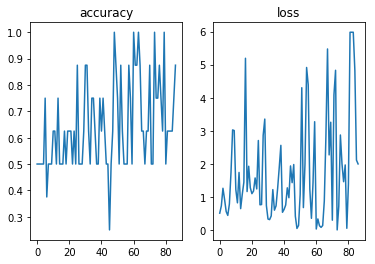

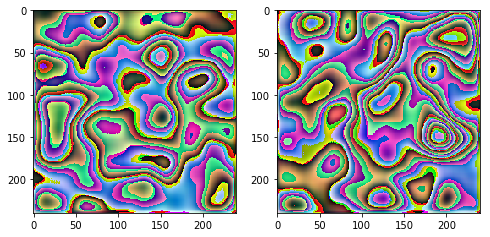

Epoch 1/3
8/8 [==============================] - 6s - loss: 1.9928 - acc: 0.8750
Epoch 2/3
8/8 [==============================] - 7s - loss: 1.9928 - acc: 0.8750
Epoch 3/3
8/8 [==============================] - 11s - loss: 1.9929 - acc: 0.8750
history :  {'loss': [1.9928039312362671, 1.992841362953186, 1.9928759336471558], 'acc': [0.875, 0.875, 0.875], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  10.0738
Epoch 1/3
8/8 [==============================] - 7s - loss: 3.9893 - acc: 0.7500
Epoch 2/3
8/8 [==============================] - 12s - loss: 3.7257 - acc: 0.7500
Epoch 3/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [3.9892764091491699, 3.7257342338562012, 8.0590476989746094], 'acc': [0.75, 0.75, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 7s - loss: 8.0590 - a

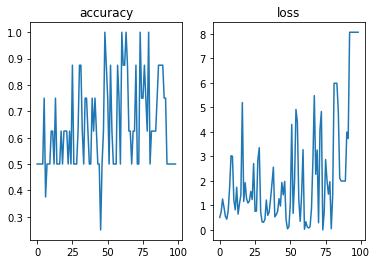

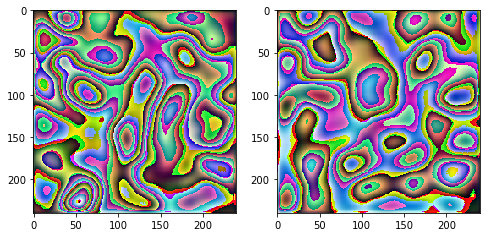

Epoch 1/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 7s - loss: 7.7449 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 7s - loss: 2.3026 - acc: 0.7500
history :  {'loss': [8.0590476989746094, 7.7449216842651367, 2.3026056289672852], 'acc': [0.5, 0.5, 0.75], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  4.02955
Epoch 1/3
8/8 [==============================] - 7s - loss: 1.9928 - acc: 0.8750
Epoch 2/3
8/8 [==============================] - 7s - loss: 1.9928 - acc: 0.8750
Epoch 3/3
8/8 [==============================] - 7s - loss: 1.9928 - acc: 0.8750
history :  {'loss': [1.9927980899810791, 1.9928025007247925, 1.9927983283996582], 'acc': [0.875, 0.875, 0.875], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  4.02961
Epoch 1/3
8/8 [==============================] - 7s - loss: 7.9712 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 7s - loss: 7.9712 - acc

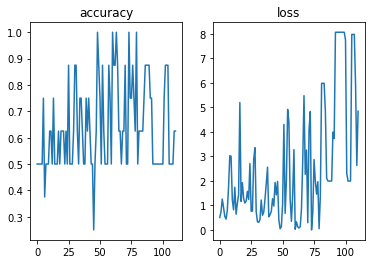

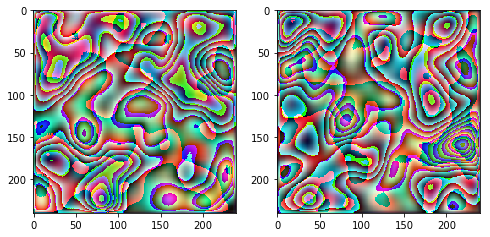

Epoch 1/3
8/8 [==============================] - 10s - loss: 1.0086 - acc: 0.8750
Epoch 2/3
8/8 [==============================] - 8s - loss: 1.1599e-05 - acc: 1.0000
Epoch 3/3
8/8 [==============================] - 12s - loss: 1.4252e-05 - acc: 1.0000
history :  {'loss': [1.0085511207580566, 1.1598933269851841e-05, 1.4251605534809642e-05], 'acc': [0.875, 1.0, 1.0], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 10s - loss: 3.9856 - acc: 0.7500
Epoch 2/3
8/8 [==============================] - 10s - loss: 3.9856 - acc: 0.7500
Epoch 3/3
8/8 [==============================] - 10s - loss: 3.9856 - acc: 0.7500
history :  {'loss': [3.985598087310791, 3.9855961799621582, 3.9855961799621582], 'acc': [0.75, 0.75, 0.75], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  10.8564
Epoch 1/3
8/8 [==============================] - 9s - loss: 5.9802 - acc: 0.6250
Epoch 2/3
8/8 [==============================] - 9s - 

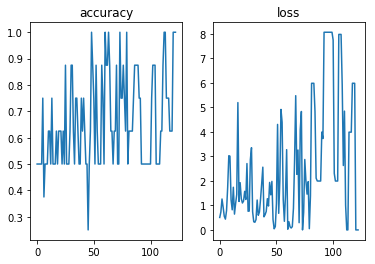

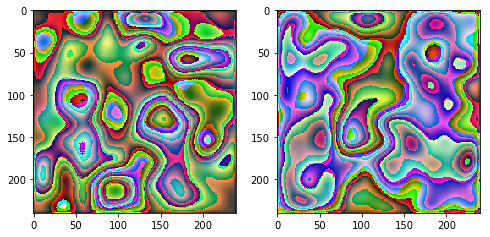

Epoch 1/3
8/8 [==============================] - 7s - loss: 7.7280 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 9s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 9s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [7.7279539108276367, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 9s - loss: 8.0590 - acc: 0.500

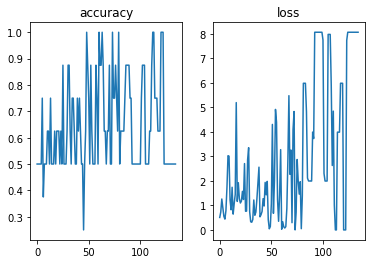

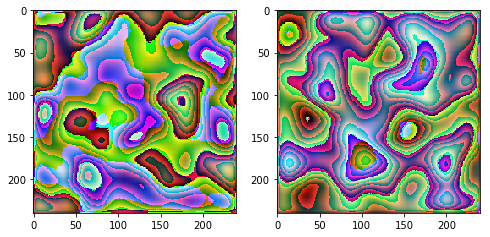

Epoch 1/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 9s - loss: 8.0590 - acc: 0.500

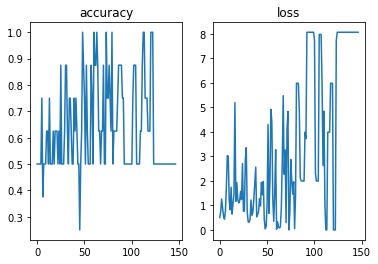

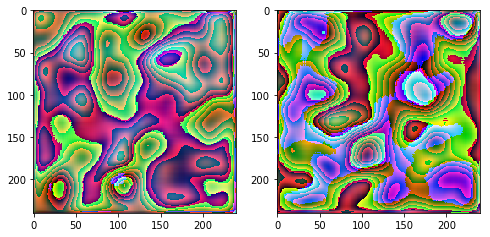

Epoch 1/3
8/8 [==============================] - 9s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 9s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 9s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 11s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.50

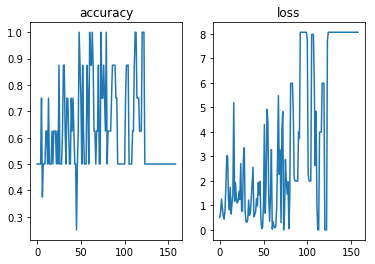

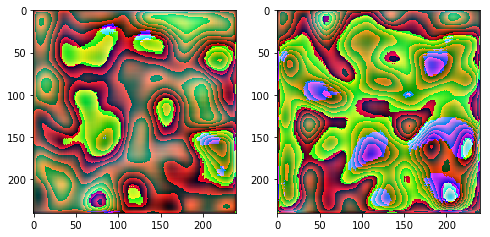

Epoch 1/3
8/8 [==============================] - 9s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 9s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 13s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 9s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 13s - loss: 8.0590 - acc: 0.5

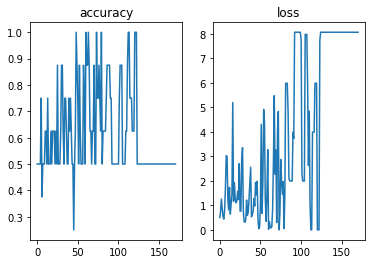

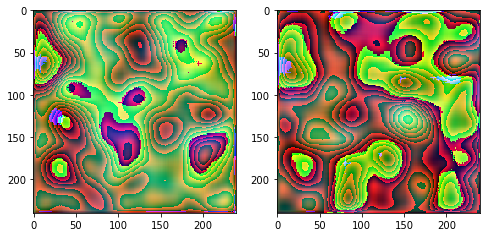

Epoch 1/3
8/8 [==============================] - 9s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 9s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 12s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 13s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 11s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 10s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 10s - loss: 8.0590 - acc: 

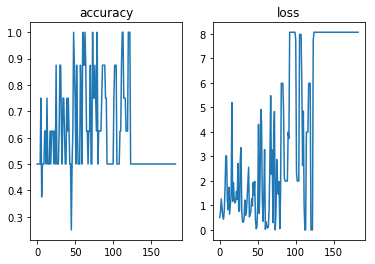

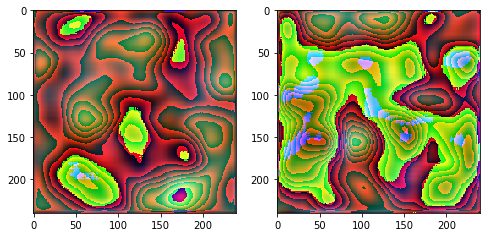

Epoch 1/3
8/8 [==============================] - 10s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 11s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 10s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.

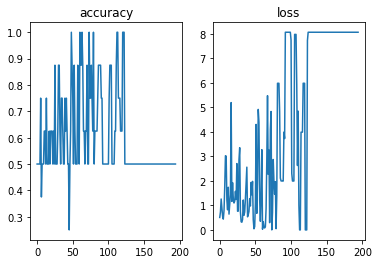

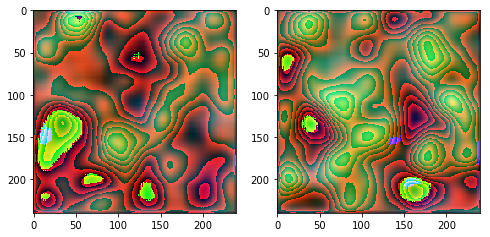

Epoch 1/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 9s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 9s - loss: 8.0590 - acc: 0.500

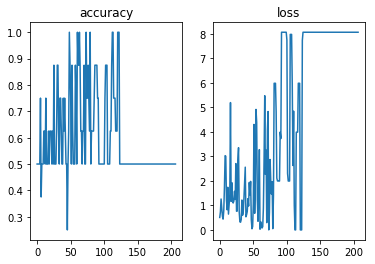

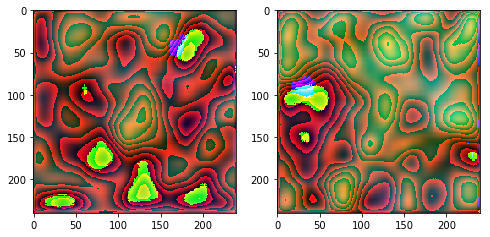

Epoch 1/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.500

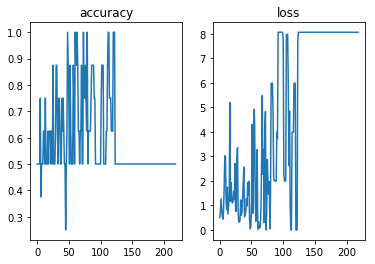

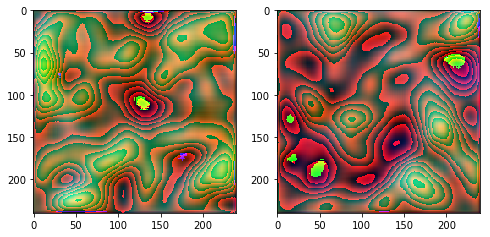

Epoch 1/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 11s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.50

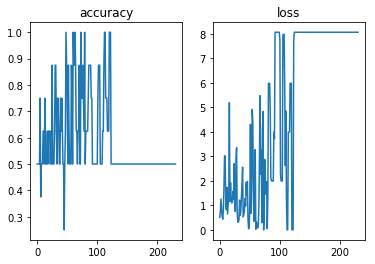

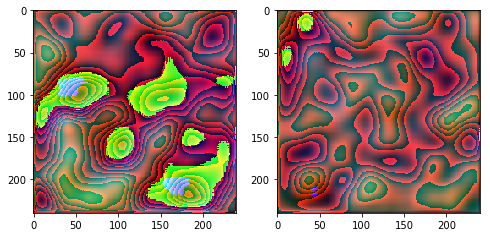

Epoch 1/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.500

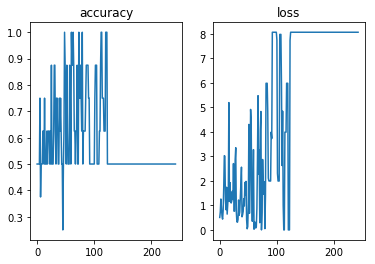

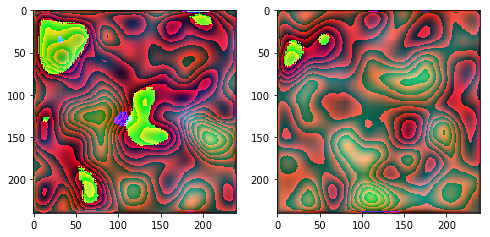

Epoch 1/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.500

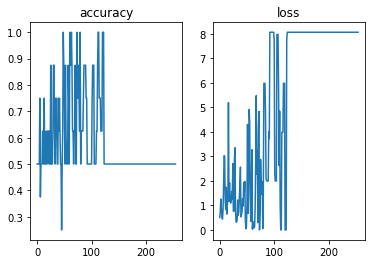

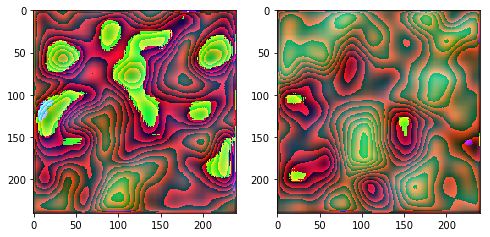

Epoch 1/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 5s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.500

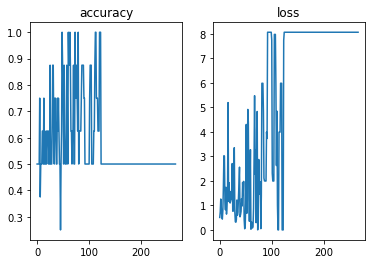

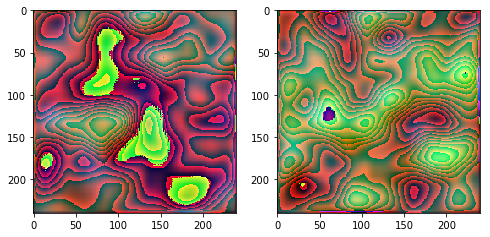

Epoch 1/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 5s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.500

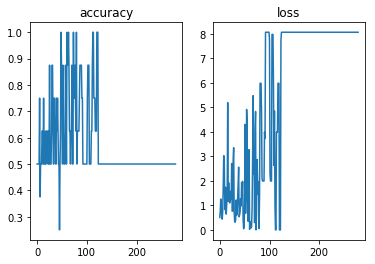

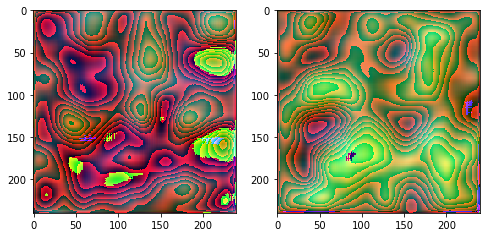

Epoch 1/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 8s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}
g_loss :  16.1181
Epoch 1/3
8/8 [==============================] - 6s - loss: 8.0590 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 7s - loss: 8.0590 - acc: 0.5000
history :  {'loss': [8.0590476989746094, 8.0590476989746094, 8.0590476989746094], 'acc': [0.5, 0.5, 0.5], 'lr': [9.9999997e-05, 9.9999997e-05, 9.9999997e-05]}


KeyboardInterrupt: 

In [59]:
# %matplotlib notebook
# %matplotlib inline

epochs = 20000
batch_size = 8
save_interval= 4
half_batch = int(batch_size / 2)

z = Input(shape=(100,))
acc = []
loss = []

img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
combined = Model(z, valid)
# combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
combined.compile(loss='binary_crossentropy', optimizer='nadam')

for epoch in range(epochs):
    d_input, d_output = getData(half_batch)
    discriminator.trainable = True
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.6,
              patience=10, min_lr=0.001)
    #myPlot
    h = discriminator.fit(d_input, d_output, epochs = 3, verbose=1, callbacks=[reduce_lr])
    acc.extend(h.history.get('acc'))
    loss.extend(h.history.get('loss'))
    print('history : ', h.history)

    
    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, 100))

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)
    print('g_loss : ', g_loss)
    
    if epoch % save_interval == 0:
        plt.figure(accuracyFig.number)
        plt.subplot(1,2,1)
        plt.plot(acc, label="accuracy")
        plt.title('accuracy')
        plt.subplot(1,2,2)
        plt.title('loss')
        plt.plot(loss, label="loss")
        accuracyFig.canvas.draw()
#         plt.show()
        save_imgs(epoch)